# Gate Cutting to Reduce Circuit Depth

In [1]:
import numpy as np
from qiskit import transpile
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator, BaseSampler
from qiskit.providers.fake_provider import FakeHanoiV2 as FakeHanoi
from qiskit.quantum_info import PauliList

from circuit_knitting_toolbox.circuit_cutting import (
    decompose_gates,
    execute_experiments,
    reconstruct_expectation_values,
)

### Create a circuit to run on the backend

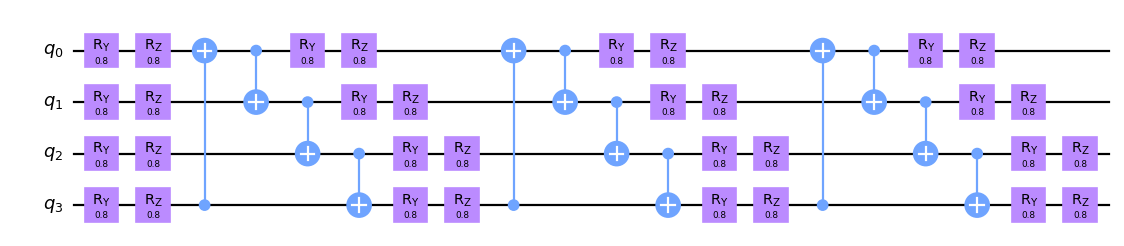

In [2]:
circuit = EfficientSU2(num_qubits=4, entanglement="circular").decompose()
circuit.assign_parameters([0.8] * len(circuit.parameters), inplace=True)
circuit.draw("mpl", scale=0.8)

### Specify some observables

In [3]:
observables = PauliList(["ZZII", "IZZI", "IIZZ", "XIXI", "iZIZZ", "-IXIX"])

### Transpile the circuit, visualize the swaps, and note the depth

We choose a layout that requires two swaps to execute the gates between qubits 3 and 0 and another two swaps to return the qubits to their initial positions.

In [4]:
backend = FakeHanoi()

transpiled_qc = transpile(circuit, backend=backend, initial_layout=[0, 1, 2, 3])
print(f"Transpiled circuit depth: {transpiled_qc.depth()}")

Transpiled circuit depth: 58


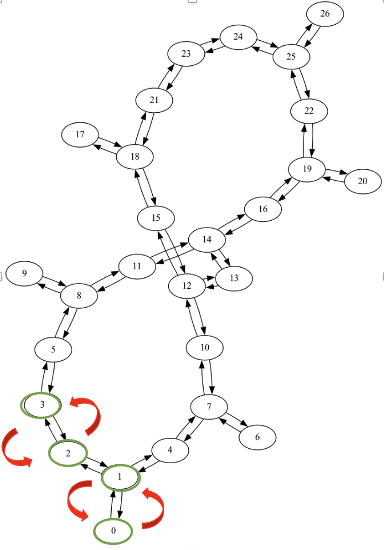

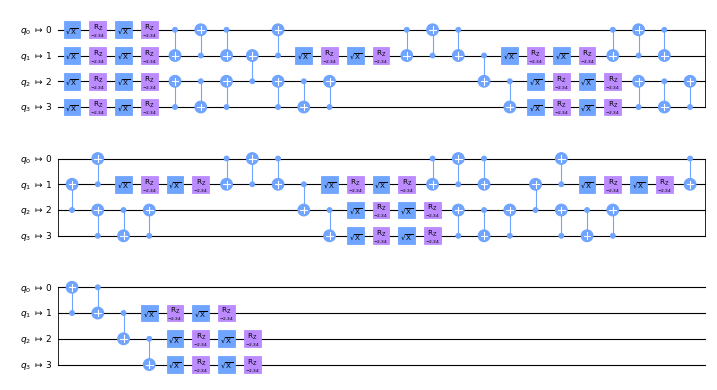

In [5]:
transpiled_qc.draw("mpl", scale=0.4, idle_wires=False)

### Replace distant gates with `TwoQubitQPDGate`s by specifying their indices

`decompose_gates` will replace the gates in the specified indices with ``TwoQubitQPDGate``s and also return a list of ``QPDBasis`` instances -- one for each gate decomposition.

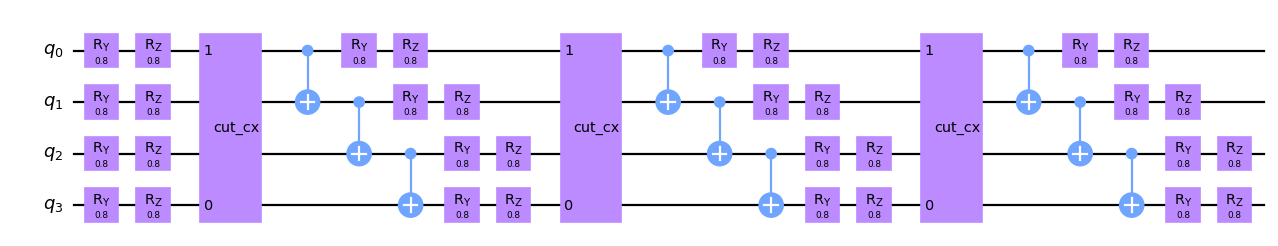

In [6]:
# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, 3}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = decompose_gates(circuit, cut_indices)
qpd_circuit.draw("mpl", scale=0.8)

### Calculate the sampling overhead for the chosen cuts

In [7]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 729.0


### Demonstrate that the QPD subexperiments will be shallower after cutting distant gates

Here is an example of one probabilistic subexperiment generated from the QPD circuit. Its depth has been reduced by more than half. Many of these probabilistic subexperiments must be generated and evaluated in order to reconstruct a simulated expectation value.

Original circuit depth after transpile: 58
QPD subexperiment depth after transpile: 24


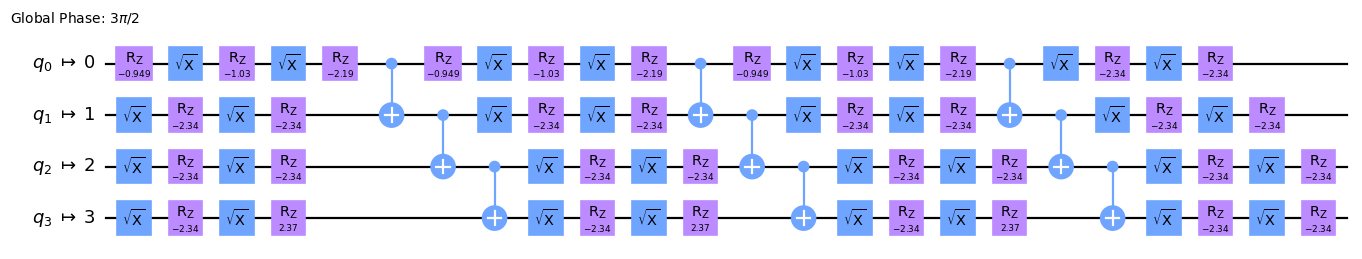

In [8]:
# Set bases to which the QPD gates should decompose
for idx in cut_indices:
    qpd_circuit[idx].operation.basis_id = 0

# Decompose TwoQubitQPDGates into SingleQubitQPDGates
qpd_circuit_dx = qpd_circuit.decompose()

# Transpile the decomposed circuit to the same layout
transpiled_qpd_circuit = transpile(
    qpd_circuit_dx, backend=backend, initial_layout=[0, 1, 2, 3]
)

print(f"Original circuit depth after transpile: {transpiled_qc.depth()}")
print(f"QPD subexperiment depth after transpile: {transpiled_qpd_circuit.depth()}")
transpiled_qpd_circuit.draw("mpl", scale=0.8, idle_wires=False)

The Qiskit primitives don't support mid-circuit measurements when used in statevector mode, so we use this helper function to retrieve an `ExactSampler` from `circuit_knitting_toolbox.utils.simulation` when exact expectation values are desired.

In [9]:
def create_sampler(shots: int = 1024) -> BaseSampler:
    if shots is None:
        return ExactSampler()
    return AerSampler(run_options={"shots":shots})

### Generate and run the subexperiments

`execute_experiments` accepts a circuit containing `TwoQubitQPDGate`s as its `circuits` argument. If a single circuit is passed in this way, a `PauliList` is the expected type of the `observables` argument. 

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends. The number of samples to take from the distribution may be specified by `num_samples`. If a sufficient number of samples is taken, the returned coefficients will be calculated exactly; otherwise, the sampled weight will be used. A `Sampler` may be specified to use for all subexperiments, as shown below.

In [10]:
%%capture

from circuit_knitting_toolbox.utils.simulation import ExactSampler

# Statevector-based sampler that supports mid-circuit measurements
sampler = create_sampler(shots=None)

quasi_dists, coefficients = execute_experiments(
    circuits=qpd_circuit,
    observables=observables,
    num_samples=1500,
    samplers=sampler,
)

`execute_experiments` returns:
 - A 3D list of length-2 tuples containing a quasiprobability distribution and QPD bit information for each unique subexperiment.
 - The coefficients for each subexperiment are also returned. If a sufficient number of samples is taken, the returned coefficients will be calculated exactly; otherwise, the sampled weight will be used.

### Reconstruct the simulated expectation values

`reconstruct_expectation_values` expects `quasi_dists` and `coefficients` in the same format as returned from `execute_experiments`. `quasi_dists` is a 3D list of shape `(num_unique_samples, num_partitions, num_commuting_observ_groups)`, and `coefficients` is a list of length `num_unique_samples`. `subobservables` is the dictionary mapping qubit partition label to the associated subobservable(s). The decomposition of this circuit did not result in separation into subcircuits, so there will be only one partition represented in these outputs.

The phase information from the observables is lost when they are decomposed. Those phases may optionally be passed in to reconstruct, using the phases argument, to be factored into each simulated expectation value.

In [11]:
# Grab the global phases from each observable
phases = np.array([(-1j) ** obs.phase for obs in observables])

simulated_expvals = reconstruct_expectation_values(
    quasi_dists,
    coefficients,
    observables,
    phases=phases,
)

The output of `reconstruct_expectation_values` is a list of simulated expectation values -- one for each observable.

### Compare simulated expectation values to exact expectation values from the original circuit

A statevector-based `Sampler` was used in this tutorial which results in exact expectation values for each subexperiment. Additionally, the number of samples taken from the joint quasiprobability distribution was sufficient to allow for exact QPD sampling weight to be calculated and used during reconstruction.

Calculating the sub-expectation values exactly and reconstructing them using exact weights should yield an exact reconstruction of the expectation value of the full circuit and observable.

In [12]:
# Aer Estimator does not support non-Hermitian observables, so we use Qiskit Estimator here
estimator = Estimator()
exact_expvals = (
    estimator.run([circuit] * len(observables), list(observables)).result().values
)
print(
    f"Simulated expectation values: {[np.round(simulated_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Exact expectation values: {[np.round(exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Errors in estimation: {[np.round(simulated_expvals[i]-exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)

Simulated expectation values: [(0.11287228+0j), (0.45443094+0j), (-0.09550941+0j), (0.2785706+0j), 0.13660985j, (-0.13428298+0j)]
Exact expectation values: [(0.11287228+0j), (0.45443094+0j), (-0.09550941+0j), (0.2785706+0j), 0.13660985j, (-0.13428298+0j)]
Errors in estimation: [0j, 0j, (-0+0j), 0j, 0j, (-0+0j)]
